In [2]:
import os

import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
import pyro
import pyro.distributions as dist
import zuko
import numpy as np
from tqdm import tqdm
import IPython
from IPython.display import HTML
import scipy

sns.set(style="white", context="notebook", palette="deep", color_codes=True)

In [3]:
# Load the data from the datafiles
base_path = "data/uav_data/failure"
experiment = "carbonZ_2018-09-11-14-41-51_elevator_failure"
field_names = {
    "failure_status-elevator": {"field.data": "elevator_status"},
    "mavros-local_position-pose": {
        "field.pose.position.x": "pose_px",
        "field.pose.position.y": "pose_py",
        "field.pose.position.z": "pose_pz",
        "field.pose.orientation.x": "pose_qx",
        "field.pose.orientation.y": "pose_qy",
        "field.pose.orientation.z": "pose_qz",
        "field.pose.orientation.w": "pose_qw",
    },
    "mavros-local_position-velocity": {
        "field.twist.linear.x": "twist_vx",
        "field.twist.linear.y": "twist_vy",
        "field.twist.linear.z": "twist_vz",
        "field.twist.angular.x": "twist_wx",
        "field.twist.angular.y": "twist_wy",
        "field.twist.angular.z": "twist_wz",
    },
    "mavros-nav_info-airspeed": {
        "field.commanded": "airspeed_commanded",
        "field.measured": "airspeed_measured",
    },
    "mavros-nav_info-errors": {
        "field.alt_error": "alt_error",
        "field.aspd_error": "airspeed_error",
        "field.xtrack_error": "xtrack_error",
        "field.wp_dist": "wp_dist",
    },
    "mavros-nav_info-pitch": {
        "field.commanded": "pitch_commanded",
        "field.measured": "pitch_measured",
    },
    "mavros-nav_info-roll": {
        "field.commanded": "roll_commanded",
        "field.measured": "roll_measured",
    },
    "mavros-nav_info-yaw": {
        "field.commanded": "yaw_commanded",
        "field.measured": "yaw_measured",
    },
    "mavros-nav_info-velocity": {
        "field.des_x": "vx_des",
        "field.des_y": "vy_des",
        "field.des_z": "vz_des",
        "field.meas_x": "vx_meas",
        "field.meas_y": "vy_meas",
        "field.meas_z": "vz_meas",
    },
}

# Load all the dfs into a list, remapping columns to the names in field_names
dfs = []
for field_name, field_map in field_names.items():
    path = os.path.join(base_path, experiment, experiment + "-" + field_name + ".csv")
    df = pd.read_csv(path)
    df.rename(columns=field_map, inplace=True)
    dfs.append(df)

# Get the min and max times
min_time = min([df["%time"].min() for df in dfs]) * 1e-9
max_time = max([df["%time"].max() for df in dfs]) * 1e-9

# Normalize and resample time
dt = 0.25
t = np.arange(0, max_time - min_time, dt)
normalized_dfs = []
for df, field_map in zip(dfs, field_names.values()):
    sampled_times = df["%time"] * 1e-9 - min_time
    normalized_df = pd.DataFrame(index=t, columns=field_map.values())
    normalized_df.index.name = "Time (s)"

    for field in field_map.values():
        # We have to treat the error status specially, since it's only reported
        # when a failure is occuring (and is implicitly zero otherwise)
        if "status" in field:
            normalized_df[field] = np.interp(t, sampled_times, df[field], left=0)
        else:
            normalized_df[field] = np.interp(t, sampled_times, df[field])

        # Handle angles to unwrap them
        if "roll" in field or "pitch" in field or "yaw" in field:
            normalized_df[field] = np.unwrap(normalized_df[field], period=360)

    normalized_dfs.append(normalized_df)

# Merge all the dataframes into one
df = pd.concat(normalized_dfs, axis=1, join="inner")

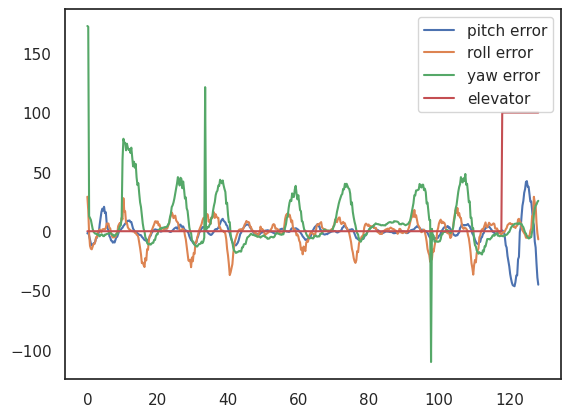

In [4]:
plt.plot(df["pitch_commanded"] - df["pitch_measured"], label="pitch error")
plt.plot(df["roll_commanded"] - df["roll_measured"], label="roll error")
plt.plot(df["yaw_commanded"] - df["yaw_measured"], label="yaw error")
plt.plot(df["elevator_status"] * 100, label="elevator")
plt.legend()

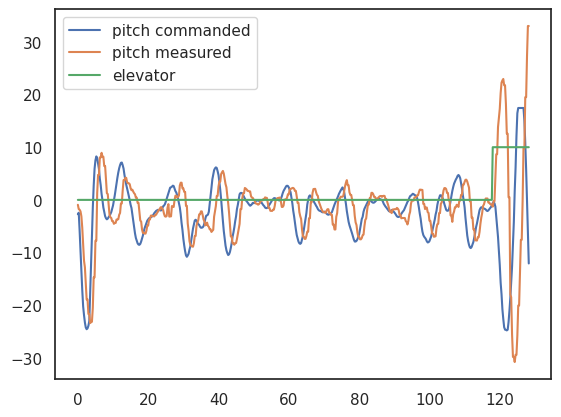

In [5]:
plt.plot(df["pitch_commanded"], label="pitch commanded")
plt.plot(df["pitch_measured"], label="pitch measured")
plt.plot(df["elevator_status"] * 10, label="elevator")
plt.legend()

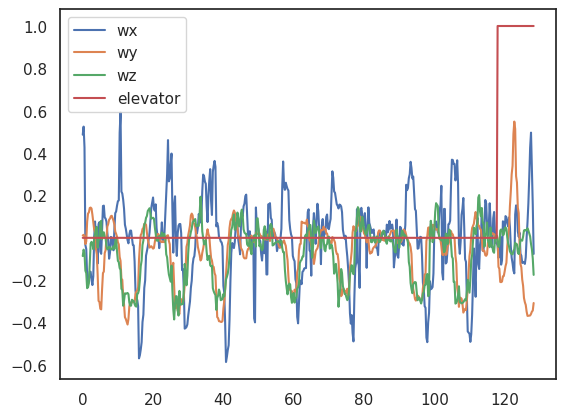

In [6]:
plt.plot(df["twist_wx"], label="wx")
plt.plot(df["twist_wy"], label="wy")
plt.plot(df["twist_wz"], label="wz")
plt.plot(df["elevator_status"] * 1, label="elevator")
plt.legend()

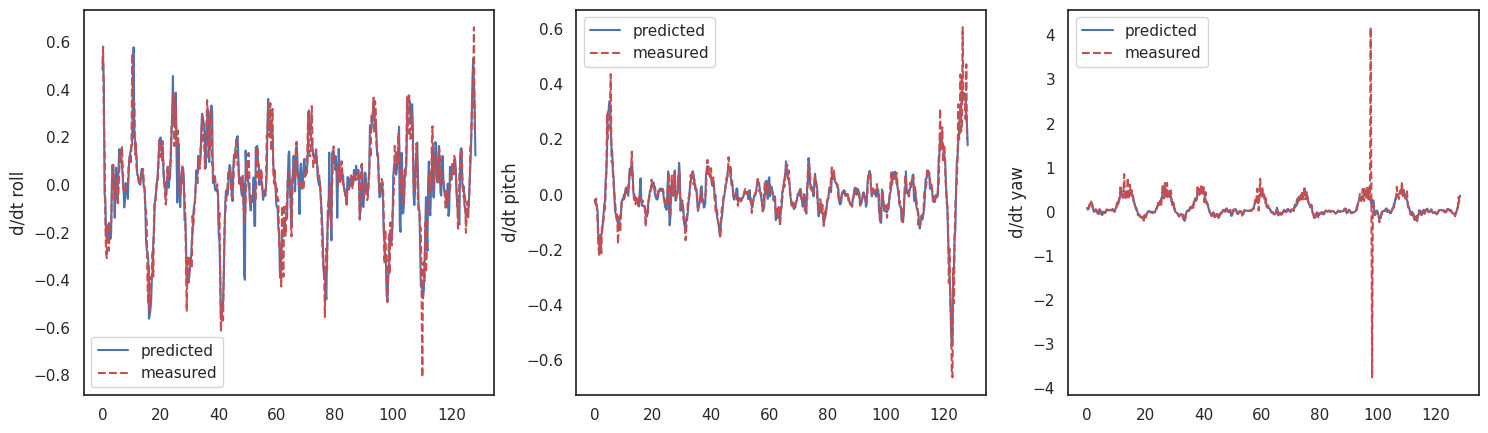

In [7]:
roll = df["roll_measured"].to_numpy() * np.pi / 180
pitch = df["pitch_measured"].to_numpy() * np.pi / 180
yaw = df["yaw_measured"].to_numpy() * np.pi / 180

roll_desired = df["roll_commanded"].to_numpy() * np.pi / 180
pitch_desired = df["pitch_commanded"].to_numpy() * np.pi / 180
yaw_desired = df["yaw_commanded"].to_numpy() * np.pi / 180

p = df["twist_wx"].to_numpy()
q = -df["twist_wy"].to_numpy()
r = -df["twist_wz"].to_numpy()

roll_dot_predicted = p + q * np.sin(roll) * np.tan(pitch) + r * np.cos(roll) * np.tan(pitch)
pitch_dot_predicted = q * np.cos(roll) - r * np.sin(roll)
yaw_dot_predicted = q * np.sin(roll) / np.cos(pitch) + r * np.cos(roll) / np.cos(pitch)

roll_dot_measured = np.diff(roll) / dt
pitch_dot_measured = np.diff(pitch) / dt
yaw_dot_measured = np.diff(yaw) / dt
kernel_size = 2
roll_dot_measured_smooth = np.convolve(roll_dot_measured, np.ones(kernel_size) / kernel_size, mode='same')
pitch_dot_measured_smooth = np.convolve(pitch_dot_measured, np.ones(kernel_size) / kernel_size, mode='same')
yaw_dot_measured_smooth = np.convolve(yaw_dot_measured, np.ones(kernel_size) / kernel_size, mode='same')

fig, axs = plt.subplots(1, 3, sharex=True, figsize=(18, 5))
axs[0].plot(t, roll_dot_predicted, "b-", label="predicted")
axs[0].plot(t[:-1], roll_dot_measured_smooth, "r--", label="measured")
axs[0].set_ylabel("d/dt roll")
axs[0].legend()

axs[1].plot(t, pitch_dot_predicted, "b-", label="predicted")
axs[1].plot(t[:-1], pitch_dot_measured_smooth, "r--", label="measured")
axs[1].set_ylabel("d/dt pitch")
axs[1].legend()

axs[2].plot(t, yaw_dot_predicted, "b-", label="predicted")
axs[2].plot(t[:-1], yaw_dot_measured_smooth, "r--", label="measured")
axs[2].set_ylabel("d/dt yaw")
axs[2].legend()

[[ 1.43593080e-01  5.21449305e-02 -6.86967292e-04]
 [ 2.36819964e-01  3.26237212e-01 -1.08764350e-03]
 [ 4.25419166e-01 -5.87558354e-02 -2.06150264e-04]]
[[ 0.99458691 -0.06372346  0.00392627]
 [-0.16338636 -0.97837657 -0.00416472]
 [-0.01439751  0.13767802  0.00264288]]
[-0.01790764  0.03379522 -0.02138898]


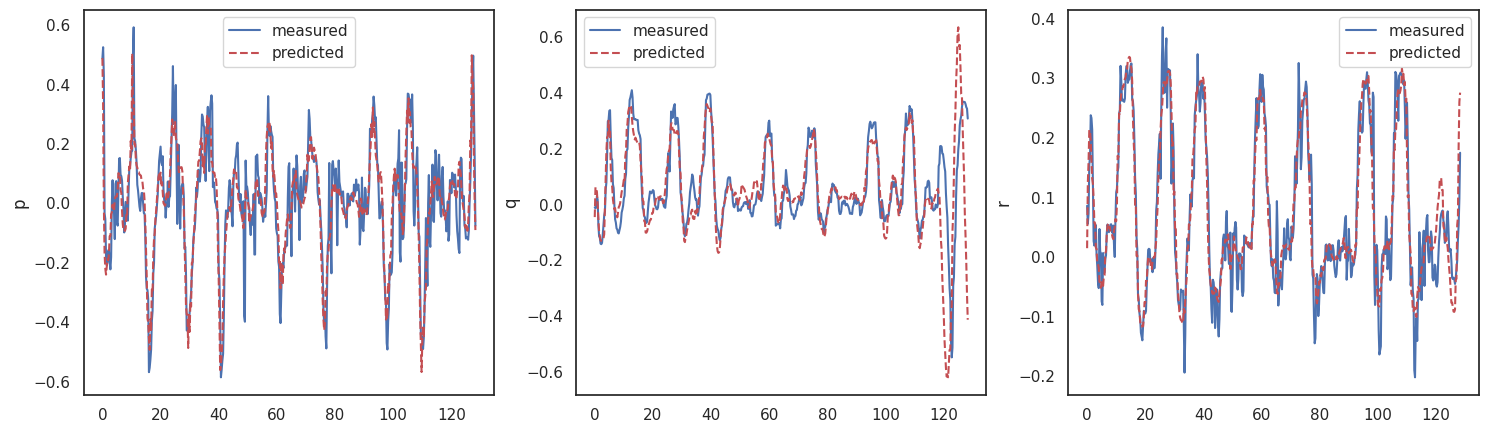

In [26]:
# Can we infer the control law? Use only the nominal period
X = np.vstack([roll_desired - roll, pitch - pitch_desired, yaw - yaw_desired, roll, pitch, yaw, np.ones(len(roll))]).T
Y = np.vstack([p, q, r]).T

num_steps = 470
coeffs, residuals, rank, singular_values = np.linalg.lstsq(X[:num_steps], Y[:num_steps], rcond=None)
Ke = coeffs.T[:, :3]
K = coeffs.T[:, 3:6]
d = coeffs.T[:, 6]
print(K)
print(Ke)
print(d)

# Plot the prediction
Y_pred = np.matmul(X, coeffs)
p_pred = Y_pred[:, 0]
q_pred = Y_pred[:, 1]
r_pred = Y_pred[:, 2]

fig, axs = plt.subplots(1, 3, sharex=True, figsize=(18, 5))
axs[0].plot(t, p, "b-", label="measured")
axs[0].plot(t, p_pred, "r--", label="predicted")
axs[0].set_ylabel("p")
axs[0].legend()

axs[1].plot(t, q, "b-", label="measured")
axs[1].plot(t, q_pred, "r--", label="predicted")
axs[1].set_ylabel("q")
axs[1].legend()

axs[2].plot(t, r, "b-", label="measured")
axs[2].plot(t, r_pred, "r--", label="predicted")
axs[2].set_ylabel("r")
axs[2].legend()

In [24]:
dfs[4]

,%time,field.header.seq,field.header.stamp,field.header.frame_id,alt_error,airspeed_error,xtrack_error,wp_dist
0,1536691595362429688,5170,1536691595360084376,NED,-0.180000,-350.749207,-31.183838,13
1,1536691595381793272,5171,1536691595380683224,NED,-0.180000,-350.749207,-31.183838,13
2,1536691595475979000,5172,1536691595472400216,NED,-0.160000,-339.113220,-29.455450,14
3,1536691595513891992,5173,1536691595512370648,NED,-0.160000,-339.113220,-29.455450,14
4,1536691595543771672,5174,1536691595541797112,NED,-0.140000,-339.113220,-27.717251,16
...,...,...,...,...,...,...,...,...
2501,1536691723525435448,7671,1536691723523028344,NED,17.389999,98.563293,-2.493698,268
2502,1536691723593857336,7672,1536691723591720184,NED,17.389999,98.563293,-2.493698,268
2503,1536691723604100120,7673,1536691723603162840,NED,16.359999,233.684448,-4.610813,269
2504,1536691723687673432,7674,1536691723682099320,NED,16.359999,233.684448,-4.610813,269


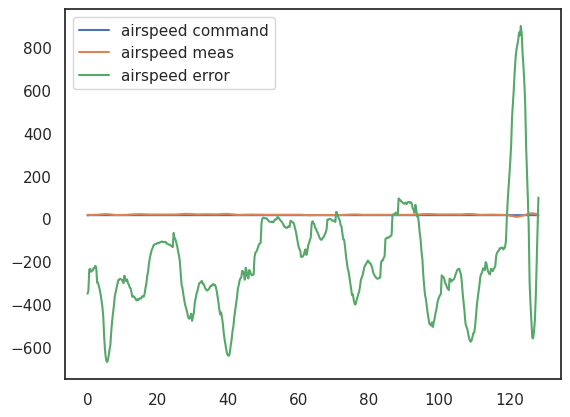

In [21]:
# plt.plot(t, df["vx_meas"], label="vx")
# plt.plot(t, df["vy_meas"], label="vy")
# plt.plot(t, df["vz_meas"], label="vz")
airspeed = np.sqrt(df["vx_meas"] ** 2 + df["vy_meas"] ** 2 + df["vz_meas"] ** 2)
plt.plot(t, df["airspeed_commanded"], label="airspeed command")
plt.plot(t, airspeed, label="airspeed meas")
plt.plot(t, df["airspeed_error"], label="airspeed error")
plt.legend()